In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [2]:
# 경로 설정
data_path = '/Data2/hm22/New/data'
saved_path = '/Data2/hm22/New/code/saved'
output_path = '/Data2/hm22/New/code/submission'

In [3]:
# 데이터 불러오기 
history = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# buy = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')  # 사용 X
search = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

In [4]:
hd = history.copy()
wd = watch.copy()
#bd = buy.copy()
sd = search.copy()
prd = profile.copy()

In [5]:
print('hd 데이터(중복 제거 전) : ', hd.shape)
print('wd 데이터(중복 제거 전) : ', wd.shape)
print('sd 데이터(중복 제거 전) : ', sd.shape)
print('prd 데이터(중복 제거 전) : ', prd.shape)

hd 데이터(중복 제거 전) :  (1005651, 8)
wd 데이터(중복 제거 전) :  (892794, 8)
sd 데이터(중복 제거 전) :  (6474, 5)
prd 데이터(중복 제거 전) :  (8311, 9)


### 1. 중복 데이터 제거

In [6]:
# 중복행 확인
hd[hd.duplicated()] # 시청시작 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
517,5,20220421082427,20220421082957,MKID003,92,NaN,N,N
519,5,20220421082427,20220421085009,MKID003,174,NaN,N,N
521,5,20220421082427,20220421090237,MKID003,201,NaN,N,N
523,5,20220421082427,20220421090332,MKID003,187,NaN,N,N
525,5,20220421082427,20220421090449,MKID003,305,NaN,N,N
...,...,...,...,...,...,...,...,...
1004498,32908,20220420203843,20220420204139,MKID003,6458,NaN,N,N
1005467,33015,20220424194027,20220424194036,MKID003,416,NaN,Y,N
1005469,33015,20220424194027,20220424194091,MKID003,175,NaN,N,Y
1005471,33015,20220424195608,20220424195612,MKID003,57,NaN,N,N


In [7]:
wd[wd.duplicated()] # 시청종료 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
507,5,20220421082427,20220421082953,MKID049,298,307,309,1
509,5,20220421082427,20220421085005,MKID049,92,1207,1207,1
511,5,20220421082427,20220421090233,MKID049,174,744,745,1
513,5,20220421082427,20220421090327,MKID049,201,50,50,1
515,5,20220421082427,20220421090443,MKID049,187,70,70,1
...,...,...,...,...,...,...,...,...
892571,33016,20220424194881,20220424195327,MKID049,5873,94,94,1
892573,33016,20220424194881,20220424195543,MKID049,5874,94,94,1
892575,33016,20220424194881,20220424195570,MKID049,5874,50,94,0
892577,33016,20220424194881,20220424195683,MKID049,4598,34,95,0


In [8]:
sd[sd.duplicated()] # 검색 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id
1,59,20220303183951,20220303183914,MKID017,2141
2,59,20220303183951,20220303183914,MKID017,2141
11,59,20220401092854,20220401092812,MKID017,2157
13,59,20220401092762,20220401092842,MKID017,2158
67,572,20220306172399,20220306172797,MKID017,2867
...,...,...,...,...,...
6366,32000,20220404195999,20220404195946,MKID017,2009
6367,32000,20220404195999,20220404195946,MKID017,2009
6387,32193,20220413135709,20220413135982,MKID017,26071
6402,32322,20220328175541,20220328180237,MKID017,10006


In [9]:
prd[prd.duplicated()] # 프로필 데이터

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3


In [10]:
# 중복행 제거
hd = hd[~hd.duplicated()]
print('hd 데이터(중복 제거 후) : ', hd.shape) # 약 10% 감소

wd = wd[~wd.duplicated()]
print('wd 데이터(중복 제거 후) : ', wd.shape) # 약 10% 감소

sd = sd[~sd.duplicated()]
print('sd 데이터(중복 제거 후) : ', sd.shape)

hd 데이터(중복 제거 후) :  (899273, 8)
wd 데이터(중복 제거 후) :  (800740, 8)
sd 데이터(중복 제거 후) :  (5825, 5)


### 2. 결측치 제거

#### 2-1. History data 내 payment
**방법 설명** : 
1) ID 로 groupby를 해준 뒤, ID 별 payment의 합을 구한다.

2) ID 별 payment의 합 == 0 이면, 해당 ID 의 payment 정보는 누락된 것으로 간주한다.

3) payment 정보가 누락된 ID가 누구인지 추출한다.

4) 해당 ID의 payment 결측값을 0으로 대체한다.

5) 그 외 여전히 payment가 null인 행은 같은 ID의 과거 payment 내역을 기입한다. (이 방법은 하지 않음- 위 방법으로 payment가 null인 값은 모두 각 ID의 payment 정보가 누락된 것이 확인됨)

In [11]:
hd.isnull().sum(), wd.isnull().sum(), sd.isnull().sum()

(profile_id              0
 ss_id                   0
 log_time                0
 act_target_dtl          0
 album_id                0
 payment            840080
 continuous_play         0
 short_trailer           0
 dtype: int64,
 profile_id         0
 ss_id              0
 log_time           0
 act_target_dtl     0
 album_id           0
 watch_time         0
 total_time         0
 continuous_play    0
 dtype: int64,
 profile_id        0
 ss_id             0
 log_time          0
 act_target_dtl    0
 album_id          0
 dtype: int64)

In [12]:
def nonull(df) :
    
    print("null 값 대체 전 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 전 결측치 개수
    
    # ID 별 payment의 합을 구하기
    ddff = df.groupby('profile_id').sum()
    
    print("payment의 합 == 0인 ID 개수 : ", len(ddff[ddff['payment'] == 0.0].index)) #payment의 합 == 0인 ID 개수
    
    """
    아래 코드 잘못됨
    for i in ddff[ddff['payment'] == 0.0].index : 
        if all(dfcp['profile_id'] == i) :
            dfcp['payment_nonan'] = dfcp['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    """ 
    
    for i in ddff[ddff['payment'] == 0.0].index: 
        df[df['profile_id'] == i]
        df['payment_nonan'] = df['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    
    
    a = df[df['payment_nonan'] != 0.0]['payment']
    b = df[df['payment'].notnull()]['payment']
    
    print(a.equals(b))
    
    df.drop(labels='payment',axis=1, inplace = True)
    df.rename(columns={'payment_nonan':'payment'}, inplace = True)
    
    print("null 값 대체 후 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 후 결측치 개수
    
    return df

In [13]:
hd = nonull(hd)

null 값 대체 전 결측치 개수 :  840080
payment의 합 == 0인 ID 개수 :  6619
True
null 값 대체 후 결측치 개수 :  0


#### 2-2. Profile data 내 결측치 처리

In [14]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,1533
pr_interest_keyword_cd_3,2080
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,1693
ch_interest_keyword_cd_3,2282


**- 결측값 있는 columns**

    - pr_interest_keyword_cd_2(부모 관심 키워드2): 1533
    - pr_interest_keyword_cd_3(부모 관심 키워드3): 2080
    - ch_interest_keyword_cd_2(아이 관심 키워드2): 1693
    - ch_interest_keyword_cd_3(아이 관심 키워드3): 2282

**- 방법 : 키워드1과 동일한 값 2,3에 채우기**

In [15]:
prd[prd['pr_interest_keyword_cd_2'].isnull()]

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
7,22,F,4,P06,NaN,NaN,K01,NaN,NaN
22,74,M,2,P02,NaN,NaN,K03,NaN,NaN
33,115,M,4,P06,NaN,NaN,K01,NaN,NaN
37,122,M,3,P05,NaN,NaN,K08,NaN,NaN
41,130,F,10,P07,NaN,NaN,K06,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8290,32965,M,1,P01,NaN,NaN,K01,K08,NaN
8294,32978,F,4,P06,NaN,NaN,K06,K01,K03
8297,32984,F,4,P06,NaN,NaN,K01,K02,K04
8301,33000,M,3,P07,NaN,NaN,K01,NaN,NaN


In [16]:
prd['pr_interest_keyword_cd_2'] = prd['pr_interest_keyword_cd_2'].fillna(prd['pr_interest_keyword_cd_1'])
prd['pr_interest_keyword_cd_3'] = prd['pr_interest_keyword_cd_3'].fillna(prd['pr_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_2'] = prd['ch_interest_keyword_cd_2'].fillna(prd['ch_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_3'] = prd['ch_interest_keyword_cd_3'].fillna(prd['ch_interest_keyword_cd_1'])

In [17]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,0
pr_interest_keyword_cd_3,0
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,0
ch_interest_keyword_cd_3,0


### 3. 이상치 제거

#### 3-1. History_data 내 log_time 이상치 제거

In [18]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0


In [19]:
# log_time 날짜/시간 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["date"] = hd["log_time"].str.slice(0, 8)
hd["time"] = hd["log_time"].str.slice(8, 14)

In [20]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,20220301,115719
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,20220301,115809
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,20220301,115958
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,20220301,120118
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,20220301,120229


In [21]:
# 월 조건 (3 ~ 7월 제외한 월이 있는지)
con1 = (hd['date'].str[4:6] != '03')
con2 = (hd['date'].str[4:6] != '04')
con3 = (hd['date'].str[4:6] != '05')
con4 = (hd['date'].str[4:6] != '06')
con5 = (hd['date'].str[4:6] != '07')

# 일 조건 (0일 / 00일 / 32일 이상 있는지)
con8 = (hd['date'].str[6:8] == '0')
con9 = (hd['date'].str[6:8] == '00')
con10 = (hd['date'].str[6:8].astype(int) >= 32)

In [22]:
print('조건에 맞지 않는 연도 수:', len(hd.loc[hd['date'].str[:4] != '2022']))
print('조건에 맞지 않는 월 수:', len(hd.loc[con1 & con2 & con3 & con4 & con5]))
print('조건에 맞지 않는 일 수:', len(hd.loc[con8 | con9 | con10]))
print('조건에 맞지 않는 시 수:', len(hd.loc[hd['time'].str[:2] >= '24']))
print('조건에 맞지 않는 분 수:', len(hd.loc[hd['time'].str[2:4] >= '60']))
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 연도 수: 0
조건에 맞지 않는 월 수: 0
조건에 맞지 않는 일 수: 0
조건에 맞지 않는 시 수: 0
조건에 맞지 않는 분 수: 0
조건에 맞지 않는 초 수: 73581


In [23]:
# 초에만 이상 있음
# 이상 있는 데이터 73,581개
hd.loc[hd['time'].str[4:6] >= '60']

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
2975,30,20220305130048,20220305131273,MKID003,1901,Y,N,0.0,20220305,131273
2976,30,20220305130048,20220305132966,MKID003,1902,Y,N,0.0,20220305,132966
2978,30,20220305130048,20220305134092,MKID003,1903,Y,N,0.0,20220305,134092
2983,30,20220320140092,20220320140174,MKID003,446,N,N,500.0,20220320,140174
2988,30,20220320140092,20220320144788,MKID003,1908,Y,N,500.0,20220320,144788
...,...,...,...,...,...,...,...,...,...,...
1005638,33032,20220427151499,20220427154870,MKID003,7105,N,N,0.0,20220427,154870
1005639,33032,20220427151499,20220427155075,MKID003,1725,Y,N,0.0,20220427,155075
1005646,33032,20220427155091,20220427155668,MKID003,381,Y,N,0.0,20220427,155668
1005647,33032,20220427155091,20220427155680,MKID003,381,Y,N,0.0,20220427,155680


In [24]:
# 이상 데이터 제거
hd = hd.drop(hd.loc[hd['time'].str[4:6] >= '60'].index)
print('이상 데이터 제거 후:', len(hd))

이상 데이터 제거 후: 825692


In [25]:
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 초 수: 0


In [26]:
hd.drop(labels=['date', 'time'],axis=1, inplace = True)

In [27]:
# log_time type 다시 int형으로 변경
hd["log_time"] = hd["log_time"].astype(int)

#### 3-2. Watch_data 내 시청시간, 콘텐츠 길이 이상치 제거

<span style='background-color: #ffdce0'>**방법 1**</span>

In [28]:
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
0,3,20220301115653,20220301115805,MKID049,15,46,46,1
1,3,20220301115653,20220301115954,MKID049,16,104,105,1
2,3,20220301115653,20220301120114,MKID049,17,76,76,1
3,3,20220301115653,20220301120226,MKID049,18,67,68,1
4,3,20220301115653,20220301120400,MKID049,19,90,90,0


In [29]:
target_outlier_wd = ['watch_time', 'total_time']
outlier_wd = wd[['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id', 'continuous_play'] + target_outlier_wd]
outlier_wd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,20220301115653,20220301115805,MKID049,15,1,46,46
1,3,20220301115653,20220301115954,MKID049,16,1,104,105
2,3,20220301115653,20220301120114,MKID049,17,1,76,76
3,3,20220301115653,20220301120226,MKID049,18,1,67,68
4,3,20220301115653,20220301120400,MKID049,19,0,90,90
...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,1,463,464
892790,33032,20220427155091,20220427155694,MKID049,381,1,462,463
892791,33032,20220427155839,20220427155826,MKID049,125,0,10,520
892792,33032,20220427155706,20220427155836,MKID049,125,0,6,521


In [30]:
import pandas as pd # 이거 import 다시 해줘야 에러 안남 왜지
criteria = pd.DataFrame()

for col in target_outlier_wd :
    values = outlier_wd[col]
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    criteria = pd.concat([criteria, values.between(lower_bound,upper_bound)], axis=1)
    

# AttributeError: 'DataFrame' object has no attribute 'DataFrame' 에러 나만 뜨는건가...후

In [31]:
outlier_wd = outlier_wd[criteria.all(axis=1)]
outlier_wd

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time
0,3,20220301115653,20220301115805,MKID049,15,1,46,46
1,3,20220301115653,20220301115954,MKID049,16,1,104,105
2,3,20220301115653,20220301120114,MKID049,17,1,76,76
3,3,20220301115653,20220301120226,MKID049,18,1,67,68
4,3,20220301115653,20220301120400,MKID049,19,0,90,90
...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,1,463,464
892790,33032,20220427155091,20220427155694,MKID049,381,1,462,463
892791,33032,20220427155839,20220427155826,MKID049,125,0,10,520
892792,33032,20220427155706,20220427155836,MKID049,125,0,6,521


In [32]:
print('wd 데이터(이상치 제거 전) : ', wd.shape)
print('wd 데이터(이상치 제거 후) : ', outlier_wd.shape)

wd 데이터(이상치 제거 전) :  (800740, 8)
wd 데이터(이상치 제거 후) :  (767008, 8)


In [33]:
wd = outlier_wd
wd

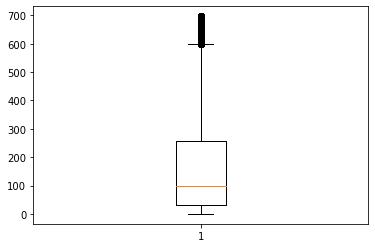

In [34]:
fig, ax = plt.subplots()
ax.boxplot(wd['watch_time'])
plt.show()

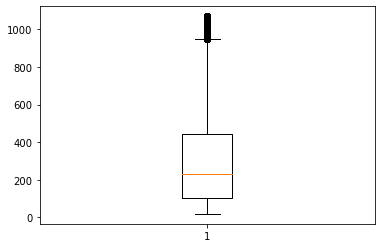

In [35]:
fig, ax = plt.subplots()
ax.boxplot(wd['total_time'])
plt.show()

<span style='background-color: #ffdce0'>**방법 2 : LocalOutlierFactor 사용**</span>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(wd['watch_time'])
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(wd['total_time'])
plt.show()

In [ ]:
wd02 = wd.copy()
wd02 = wd02[['watch_time', 'total_time']]

In [ ]:
outlier = LocalOutlierFactor()
wd02["outlier"] = outlier.fit_predict(wd02)

In [ ]:
# 이상치 탐지 (이상치 있는 행 찾기)
wd02[wd02["outlier"] == -1]

In [ ]:
wd = wd.drop(wd02[wd02["outlier"] == -1].index, axis = 0)

In [ ]:
print('wd 데이터(이상치 제거 후) : ', wd.shape) # wd 데이터(이상치 제거 전) :  (800740, 8)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(wd['watch_time'])
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(wd['total_time'])
plt.show()

#### 3-3. History_data 내 payment 이상치 제거

<span style='background-color: #ffdce0'>이상치 제거해도 되려나? -> 구간 나누기는 어떨지?</span>

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(hd['payment'])
plt.show()

### 4. 파생변수

#### 4-1. 선호도('prefer') 변수

In [36]:
wd.tail()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time
892789,33032,20220427155091,20220427155653,MKID049,381,1,463,464
892790,33032,20220427155091,20220427155694,MKID049,381,1,462,463
892791,33032,20220427155839,20220427155826,MKID049,125,0,10,520
892792,33032,20220427155706,20220427155836,MKID049,125,0,6,521
892793,33032,20220427155839,20220427155897,MKID049,381,1,462,464


In [37]:
#컬럼추가
wd_prefer = wd.copy()
wd_prefer['prefer'] = np.nan
wd_prefer.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time,prefer
0,3,20220301115653,20220301115805,MKID049,15,1,46,46,NaN
1,3,20220301115653,20220301115954,MKID049,16,1,104,105,NaN
2,3,20220301115653,20220301120114,MKID049,17,1,76,76,NaN
3,3,20220301115653,20220301120226,MKID049,18,1,67,68,NaN
4,3,20220301115653,20220301120400,MKID049,19,0,90,90,NaN


In [38]:
#조건걸어서
#새컬럼에 값추가 1 ~ 4

for i in wd_prefer.index : 
    
    try : 
        #wd_prefer_check = wd_prefer.iloc[i]
        if wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.25 :
            wd_prefer.loc[i,'prefer'] = 1
        elif wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.5 :
            wd_prefer.loc[i,'prefer'] = 2
        elif wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.75 :
            wd_prefer.loc[i,'prefer'] = 3
        else : 
            wd_prefer.loc[i,'prefer'] = 4
        
    except : 
        pass

In [39]:
wd = wd_prefer
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time,prefer
0,3,20220301115653,20220301115805,MKID049,15,1,46,46,4.0
1,3,20220301115653,20220301115954,MKID049,16,1,104,105,4.0
2,3,20220301115653,20220301120114,MKID049,17,1,76,76,4.0
3,3,20220301115653,20220301120226,MKID049,18,1,67,68,4.0
4,3,20220301115653,20220301120400,MKID049,19,0,90,90,4.0


In [40]:
print('wd 데이터(행 삭제 완료) : ', wd.shape)

wd 데이터(행 삭제 완료) :  (767008, 9)


#### 4-2. log_time 파생변수 생성
- 6시간 기준으로 나누기
- 참고문헌
- 2개 이상의 조건이 있을 때
    - https://www.delftstack.com/ko/howto/python-pandas/how-to-create-dataframe-column-based-on-given-condition-in-pandas/
- 새로운 변수 생성
    - 00_06: log_time이 00-06시 사이
    - 06_12: log_time이 06-12시 사이
    - 12_18: log_time이 12-18시 사이
    - 18_24: log_time이 18-24시 사이

In [41]:
# log_time에서 시간만 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["time"] = hd["log_time"].str[8:10].astype(int)

In [42]:
conditionlist = [
    (hd['time'] < 6) ,
    (hd['time'] >= 6) & (hd['time'] < 12),
    (hd['time'] >= 12) & (hd['time'] < 18),
    (hd['time'] >= 18) & (hd['time'] < 24)]
choicelist = [1, 2, 3, 4]
hd['time_slot'] = np.select(conditionlist, choicelist)

In [43]:
hd = hd.drop(['time'], axis = 1) # time열 drop
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,time_slot
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,2
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,2
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,2
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,3
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,3


In [44]:
# log_time에서 시간만 분리
wd["log_time"] = wd["log_time"].astype(str)
wd["time"] = wd["log_time"].str[8:10].astype(int)

In [45]:
conditionlist = [
    (wd['time'] < 6) ,
    (wd['time'] >= 6) & (wd['time'] < 12),
    (wd['time'] >= 12) & (wd['time'] < 18),
    (wd['time'] >= 18) & (wd['time'] < 24)]
choicelist = [1, 2, 3, 4]
wd['time_slot'] = np.select(conditionlist, choicelist)

In [46]:
wd = wd.drop(['time'], axis = 1) # time열 drop
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time,prefer,time_slot
0,3,20220301115653,20220301115805,MKID049,15,1,46,46,4.0,2
1,3,20220301115653,20220301115954,MKID049,16,1,104,105,4.0,2
2,3,20220301115653,20220301120114,MKID049,17,1,76,76,4.0,3
3,3,20220301115653,20220301120226,MKID049,18,1,67,68,4.0,3
4,3,20220301115653,20220301120400,MKID049,19,0,90,90,4.0,3


In [47]:
wd["log_time"] = wd["log_time"].astype(int)
hd["log_time"] = hd["log_time"].astype(int)

### 5. 기초

#### 5-1. 필요없는 column drop
    - hd : ss_id
    - wd : ss_id, log_time
    - sd : ss_id
    
## -> merge 시 ss_id 필요함 나중에 제거

In [ ]:
"""
hd = hd.drop(["ss_id"], axis=1)
sd = sd.drop(["ss_id"], axis=1)
wd = wd.drop(["ss_id", "log_time"], axis=1)

print('hd 데이터(행 삭제 완료) : ', hd.shape)
print('wd 데이터(행 삭제 완료) : ', wd.shape)
print('sd 데이터(행 삭제 완료) : ', sd.shape)
"""

#### 5-2. hd의 continuous_play,  wd의 continuous_play 동일하게 바꿔주기

In [48]:
hd['continuous_play'].value_counts().to_frame()

,continuous_play
Y,761902
N,63790


In [49]:
# 시청 시작 데이터에서 연속재생여부 Y -> 1: 연속재생, N -> 5: 미정 으로 변환
hd.loc[(hd['continuous_play'] == 'Y'), 'continuous_play'] = 1
hd.loc[(hd['continuous_play'] == 'N'), 'continuous_play'] = 0

# 시청 종료 데이터에서 연속재생 1이 아닌 경우 (0,2,3) -> 0으로 변환
wd.loc[(wd['continuous_play'] == 2) |
       (wd['continuous_play'] == 3), 'continuous_play'] = 0

In [50]:
hd['continuous_play'].value_counts().to_frame()

,continuous_play
1,761902
0,63790


In [51]:
wd['continuous_play'].value_counts().to_frame()

,continuous_play
1,434262
0,332746


In [52]:
##### 중간 저장

# 각 데이터셋 저장
hd.to_csv('hd_v1_iqr.csv')
wd.to_csv('wd_v1_iqr.csv')
sd.to_csv('sd_v1_iqr.csv')
prd.to_csv('prd_v1_iqr.csv')

In [ ]:
#### 인코딩 전 저장

In [ ]:
# 데이터 불러오기 
"""
hd = pd.read_csv('/Data2/hm22/New/hd_v1_lof.csv', encoding='utf-8')
wd = pd.read_csv('/Data2/hm22/New/wd_v1_lof.csv', encoding='utf-8')
sd = pd.read_csv('/Data2/hm22/New/sd_v1_lof.csv', encoding='utf-8')
prd = pd.read_csv('/Data2/hm22/New/prd_v1_lof.csv', encoding='utf-8')

hd = hd.drop(['Unnamed: 0'], axis = 1)
wd = wd.drop(['Unnamed: 0'], axis = 1)
sd = sd.drop(['Unnamed: 0'], axis = 1)
prd = prd.drop(['Unnamed: 0'], axis = 1)

In [ ]:
## 1. HD(시청 시작) + SD(검색 후 시청 시작)

In [53]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,time_slot
0,3,20220301115653,20220301115719,MKID003,15,1,N,0.0,2
1,3,20220301115653,20220301115809,MKID003,16,1,N,0.0,2
2,3,20220301115653,20220301115958,MKID003,17,1,N,0.0,2
3,3,20220301115653,20220301120118,MKID003,18,1,N,0.0,3
4,3,20220301115653,20220301120229,MKID003,19,1,N,0.0,3


In [54]:
sd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id
0,59,20220303183951,20220303183914,MKID017,2141
3,59,20220304181433,20220304181525,MKID017,512
4,59,20220304181433,20220304182447,MKID017,2141
5,59,20220312071555,20220312071637,MKID017,2142
6,59,20220312071555,20220312081857,MKID017,2142


In [ ]:
#hd["log_time"] = hd["log_time"].astype(int)

In [55]:
df01 = pd.merge(hd, sd, on = ['profile_id', 'album_id', 'log_time'], how = 'left')
df01 = df01.drop(['ss_id_y'], axis = 1)
df01

,profile_id,ss_id_x,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,time_slot,act_target_dtl_y
0,3,20220301115653,20220301115719,MKID003,15,1,N,0.0,2,NaN
1,3,20220301115653,20220301115809,MKID003,16,1,N,0.0,2,NaN
2,3,20220301115653,20220301115958,MKID003,17,1,N,0.0,2,NaN
3,3,20220301115653,20220301120118,MKID003,18,1,N,0.0,3,NaN
4,3,20220301115653,20220301120229,MKID003,19,1,N,0.0,3,NaN
...,...,...,...,...,...,...,...,...,...,...
825687,33032,20220427155091,20220427155601,MKID003,381,1,N,0.0,3,NaN
825688,33032,20220427155091,20220427155611,MKID003,381,1,N,0.0,3,NaN
825689,33032,20220427155091,20220427155642,MKID003,381,0,N,0.0,3,NaN
825690,33032,20220427155839,20220427155810,MKID003,125,1,N,0.0,3,NaN


In [56]:
hd.shape, df01.shape

((825692, 9), (825692, 10))

In [57]:
df01.isnull().sum().to_frame() # act_target_dtl_y NaN인 것 -> 검색 후 시청 안한 것

,0
profile_id,0
ss_id_x,0
log_time,0
act_target_dtl_x,0
album_id,0
continuous_play,0
short_trailer,0
payment,0
time_slot,0
act_target_dtl_y,825681


In [ ]:
## 2. HD(시청 시작) + SD(검색 후 시청 시작) + WD(시청 종료)

In [58]:
df01.head()

,profile_id,ss_id_x,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,time_slot,act_target_dtl_y
0,3,20220301115653,20220301115719,MKID003,15,1,N,0.0,2,NaN
1,3,20220301115653,20220301115809,MKID003,16,1,N,0.0,2,NaN
2,3,20220301115653,20220301115958,MKID003,17,1,N,0.0,2,NaN
3,3,20220301115653,20220301120118,MKID003,18,1,N,0.0,3,NaN
4,3,20220301115653,20220301120229,MKID003,19,1,N,0.0,3,NaN


In [59]:
df01.rename(columns={'ss_id_x':'ss_id'}, inplace = True)

In [60]:
df01

,profile_id,ss_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,time_slot,act_target_dtl_y
0,3,20220301115653,20220301115719,MKID003,15,1,N,0.0,2,NaN
1,3,20220301115653,20220301115809,MKID003,16,1,N,0.0,2,NaN
2,3,20220301115653,20220301115958,MKID003,17,1,N,0.0,2,NaN
3,3,20220301115653,20220301120118,MKID003,18,1,N,0.0,3,NaN
4,3,20220301115653,20220301120229,MKID003,19,1,N,0.0,3,NaN
...,...,...,...,...,...,...,...,...,...,...
825687,33032,20220427155091,20220427155601,MKID003,381,1,N,0.0,3,NaN
825688,33032,20220427155091,20220427155611,MKID003,381,1,N,0.0,3,NaN
825689,33032,20220427155091,20220427155642,MKID003,381,0,N,0.0,3,NaN
825690,33032,20220427155839,20220427155810,MKID003,125,1,N,0.0,3,NaN


In [61]:
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,watch_time,total_time,prefer,time_slot
0,3,20220301115653,20220301115805,MKID049,15,1,46,46,4.0,2
1,3,20220301115653,20220301115954,MKID049,16,1,104,105,4.0,2
2,3,20220301115653,20220301120114,MKID049,17,1,76,76,4.0,3
3,3,20220301115653,20220301120226,MKID049,18,1,67,68,4.0,3
4,3,20220301115653,20220301120400,MKID049,19,0,90,90,4.0,3


In [62]:
%%time
df02 = pd.merge(df01, wd, on = ['profile_id', 'ss_id', 'continuous_play'], how = 'outer')
df02

CPU times: user 3.77 s, sys: 22.4 s, total: 26.2 s
Wall time: 26.3 s


,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id_x,continuous_play,short_trailer,payment,time_slot_x,act_target_dtl_y,log_time_y,act_target_dtl,album_id_y,watch_time,total_time,prefer,time_slot_y
0,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,15.0,46.0,46.0,4.0,2.0
1,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,16.0,104.0,105.0,4.0,2.0
2,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,17.0,76.0,76.0,4.0,3.0
3,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,18.0,67.0,68.0,4.0,3.0
4,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,20.0,119.0,119.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469669,33032,20220427150528,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,1.0,74.0,1.0,3.0
10469670,33032,20220427150528,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,64.0,65.0,4.0,3.0
10469671,33032,20220427151326,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,5255.0,71.0,707.0,1.0,3.0
10469672,33032,20220427155839,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,125.0,10.0,520.0,1.0,3.0


In [63]:
df02.isnull().sum().to_frame()

,0
profile_id,0
ss_id,0
log_time_x,249400
act_target_dtl_x,249400
album_id_x,249400
continuous_play,0
short_trailer,249400
payment,249400
time_slot_x,249400
act_target_dtl_y,10469544


In [64]:
# 중간 저장
df02.to_csv('dfv0_iqr.csv')

In [70]:
df02

,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id_x,continuous_play,short_trailer,payment,time_slot_x,act_target_dtl_y,log_time_y,act_target_dtl,album_id_y,watch_time,total_time,prefer,time_slot_y
0,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,15.0,46.0,46.0,4.0,2.0
1,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,16.0,104.0,105.0,4.0,2.0
2,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,17.0,76.0,76.0,4.0,3.0
3,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,18.0,67.0,68.0,4.0,3.0
4,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,20.0,119.0,119.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469669,33032,20220427150528,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,1.0,74.0,1.0,3.0
10469670,33032,20220427150528,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,64.0,65.0,4.0,3.0
10469671,33032,20220427151326,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,5255.0,71.0,707.0,1.0,3.0
10469672,33032,20220427155839,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,125.0,10.0,520.0,1.0,3.0


In [ ]:
## 3. HD(시청 시작) + SD(검색 후 시청 시작) + WD(시청 종료) + PRD (프로필 정보)

In [65]:
df02

,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id_x,continuous_play,short_trailer,payment,time_slot_x,act_target_dtl_y,log_time_y,act_target_dtl,album_id_y,watch_time,total_time,prefer,time_slot_y
0,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,15.0,46.0,46.0,4.0,2.0
1,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,16.0,104.0,105.0,4.0,2.0
2,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,17.0,76.0,76.0,4.0,3.0
3,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,18.0,67.0,68.0,4.0,3.0
4,3,20220301115653,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,2.022030e+13,MKID049,20.0,119.0,119.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469669,33032,20220427150528,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,1.0,74.0,1.0,3.0
10469670,33032,20220427150528,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,18334.0,64.0,65.0,4.0,3.0
10469671,33032,20220427151326,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,5255.0,71.0,707.0,1.0,3.0
10469672,33032,20220427155839,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,125.0,10.0,520.0,1.0,3.0


In [66]:
prd

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,P05,K06,K04,K06
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,P04,P04,P04,K04,K08,K04
8307,33023,M,5,P06,P03,P07,K08,K04,K05
8308,33026,F,8,P01,P03,P08,K05,K09,K06
8309,33027,F,4,P04,P05,P06,K03,K01,K05


In [67]:
df02.columns, prd.columns

(Index(['profile_id', 'ss_id', 'log_time_x', 'act_target_dtl_x', 'album_id_x',
        'continuous_play', 'short_trailer', 'payment', 'time_slot_x',
        'act_target_dtl_y', 'log_time_y', 'act_target_dtl', 'album_id_y',
        'watch_time', 'total_time', 'prefer', 'time_slot_y'],
       dtype='object'),
 Index(['profile_id', 'sex', 'age', 'pr_interest_keyword_cd_1',
        'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
        'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2',
        'ch_interest_keyword_cd_3'],
       dtype='object'))

In [68]:
%%time
all_df = pd.merge(df02, prd, on = ['profile_id'], how = 'right')
all_df

CPU times: user 2.97 s, sys: 1.95 s, total: 4.93 s
Wall time: 4.92 s


,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id_x,continuous_play,short_trailer,payment,time_slot_x,act_target_dtl_y,...,prefer,time_slot_y,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,2.022030e+13,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,...,4.0,2.0,F,5,P02,P04,P07,K01,K03,K04
1,3,2.022030e+13,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,...,4.0,2.0,F,5,P02,P04,P07,K01,K03,K04
2,3,2.022030e+13,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,...,4.0,3.0,F,5,P02,P04,P07,K01,K03,K04
3,3,2.022030e+13,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,...,4.0,3.0,F,5,P02,P04,P07,K01,K03,K04
4,3,2.022030e+13,2.022030e+13,MKID003,15.0,1.0,N,0.0,2.0,NaN,...,4.0,3.0,F,5,P02,P04,P07,K01,K03,K04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469694,33032,2.022043e+13,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,1.0,3.0,F,5,P03,P05,P07,K01,K05,K09
10469695,33032,2.022043e+13,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,4.0,3.0,F,5,P03,P05,P07,K01,K05,K09
10469696,33032,2.022043e+13,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,1.0,3.0,F,5,P03,P05,P07,K01,K05,K09
10469697,33032,2.022043e+13,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,1.0,3.0,F,5,P03,P05,P07,K01,K05,K09


In [69]:
# 저장
all_df.to_csv('all_df_v0_iqr.csv')

### 6. 범주형 데이터 인코딩

범주형 변수는 다시 명목형 변수(Nominal)와 순서형 변수(Oridinal)로 구분할 수 있습니다.

- 명목형 변수 : 성별과 혈액형처럼 값이 달라짐에 따라 좋거나 나쁘다고 할 수 없는 경우

        → 여러 카테고리들 중 하나의 이름에 데이터를 분류할 수 있을 때 사용

- 순서형 변수 : 학점과 만족도 조사처럼 값이 커지거나 작아짐에 따라 좋거나 나쁘다고 할 수 있는 경우

        → 카테고리들이 순서가 있을 때 사용 (상/중/하, A+/A0/B+/B0...)

#### 6-1. History_data & Watch_data & Search_data

In [ ]:
hd.head()

- **continuous_play, short_trailer**: 이진변수 (-> 0, 1로 변경)
    - continuous_play (위 0에서 수행 완료했으므로 생략)
        - 연속재생x: 0
        - 연속재생o: 1
    - short_trailer
        - N: 0
        - Y: 1

In [ ]:
"""
hd.loc[hd['short_trailer'] == 'Y']
hd.loc[hd['short_trailer'] == 'N']
"""

In [ ]:
hd['short_trailer'] = hd['short_trailer'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
"""
hd.loc[hd['short_trailer'] == 1]
hd.loc[hd['short_trailer'] == 0]
"""

- **act_target_dtl**
    - MKID### 형태 -> MKID 문자 제거

In [ ]:
hd['act_target_dtl'] = hd['act_target_dtl'].str.split('D').str[1]
wd['act_target_dtl'] = wd['act_target_dtl'].str.split('D').str[1]
sd['act_target_dtl'] = sd['act_target_dtl'].str.split('D').str[1]

In [ ]:
hd.head()

#### 6-2. Profile_data

In [ ]:
prd.head()

- **Sex** : 이진변수
    - 0: 여자 F
    - 1: 남자 M

In [ ]:
prd['sex'] = prd['sex'].apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
prd.head()

 - **pr_interest_keyword_cd_1**
 - **pr_interest_keyword_cd_2**
 - **pr_interest_keyword_cd_3**
 - **ch_interest_keyword_cd_1**
 - **ch_interest_keyword_cd_2**
 - **ch_interest_keyword_cd_3**

<span style='background-color: #fff5b1'>**1) One-hot encoding 적용**</span>

- 컬럼이 많이 만들어짐 ⇒ 메모리 문제

In [ ]:
"""
prd = pd.get_dummies(prd)
prd
"""

<span style='background-color: #fff5b1'>**2) Label encoding 적용**</span>

- 단순히 문자형을 정수형으로 변환시켜주므로 데이터의 크기 및 shape이 변하지 않음
- 모델이 숫자의 순서를 특징으로 인식하는 문제 있음

In [ ]:
# Label Encoding
"""
from sklearn.preprocessing import LabelEncoder

for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] :
    encoder = LabelEncoder()
    encoder.fit(prd[i])
    prd[i] = encoder.transform(prd[i])
"""

<span style='background-color: #fff5b1'>**3) Target encoding 적용**</span>

- cross-validation과 smoothing을 함께 사용해서 과적합을 방지 -> smoothing 만 해봄
- 효과 미비하다는 의견 봄
- 특정한 Y 변수가 필요한데 profile_id는 없음..

In [ ]:
"""
from sklearn.preprocessing import TargetEncoder
    
for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    target_encoder = TargetEncoder(cols=[i])
    target_encoder.fit(df[i], df['y값이 없음..... 음....?'])
    new_df = pd.concat([new_df, target_encoder.transform(train[i])], axis = 1)
    #new_test = pd.concat([new_test, target_encoder.transform(test[column])], axis = 1)
new_df.head()
"""

"""
def target_encoding(var):
    mean= df['y'].mean()
    agg= df.groupby(var)['y'].agg(["count", "mean"])
    counts = agg["count"]
    means = agg["mean"]
    weight= 100
    smooth= (counts*means +weight*means) /(counts+weight)
    df.loc[:, var+"_encode_smooth"]= df[var].map(smooth)
    return df
"""

<span style='background-color: #fff5b1'>**4) Frequency encoding 적용 ✔️**</span>

In [ ]:
"""
#!pip install kaggler
import kaggler
from kaggler.preprocessing import FrequencyEncoder

for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    dff = prd.copy()
    fe = FrequencyEncoder()
    dff[i] = fe.fit_transform(prd[i])
    dff[i].head()
"""

In [ ]:
prd.isnull().sum().to_frame()

In [ ]:
# 주의 : 결측치가 없어야함
for i in ['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
          'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'] : 
    enc_1 = (prd.groupby(i).size()) / len(prd)
    enc_1
    
    prd['{}_encode'.format(i)] = prd[i].apply(lambda x : enc_1[x])
    
#인코딩 전 변수는 제거 
prd = prd.drop(['pr_interest_keyword_cd_1', 'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
                'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3'],axis=1)


In [ ]:
prd

### 7. 수치형 데이터 인코딩

In [ ]:
hd.head()

In [ ]:
wd.head()

In [ ]:
sd.head()

In [ ]:
prd.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
# Select numerical columns from dataset
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_hd = hd.select_dtypes(include=numerics)

# fig setting
sns.set(rc = {'figure.figsize':(10, 7)})
sns.set(style="white")

for col in num_hd.columns :
    sns.distplot(hd[col])

In [ ]:
hd.hist(figsize = (15, 13), color = 'green', alpha = 0.4)
plt.tight_layout() # 그래프 간격 설정
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(10, 7)})
sns.set(style="white")

sns.distplot(hd['payment']) #, kde_kws = {'color': 'g', 'alpha': 0.3,
                                       #            'linewidth': 5, 'shade': True})

In [ ]:
#로그변환
#np.log1p(df['col'])
np.log1p(hd['payment']).hist(figsize = (7, 5), color = 'green', alpha = 0.4)

In [ ]:
wd.hist(figsize = (15, 13), color = 'blue', alpha = 0.4)
plt.tight_layout() # 그래프 간격 설정
plt.show()

In [ ]:
#로그변환
#np.log1p(df['col'])
np.log1p(wd['watch_time']).hist(figsize = (7, 5), color = 'blue', alpha = 0.4)

In [ ]:
#로그변환
#np.log1p(df['col'])
np.log1p(wd['total_time']).hist(figsize = (7, 5), color = 'blue', alpha = 0.4)

- Skewed 확인 결과 : 로그변환 변수
    1. history_data : 'payment'
    2. watch_data : 'watch_time', 'total_time' 

In [ ]:
# 로그변환
hd['payment'] = np.log1p(hd['payment'])
wd['watch_time'] = np.log1p(wd['watch_time'])
wd['total_time'] = np.log1p(wd['total_time'])

In [ ]:
# 각 데이터셋 저장
hd.to_csv('hd_v1.csv')
wd.to_csv('wd_v1.csv')
sd.to_csv('sd_v1.csv')
prd.to_csv('prd_v1.csv')

### 8. 데이터 결합

In [ ]:
hd.head()

In [ ]:
wd.head()

In [ ]:
%%time
df01 = pd.merge(hd, wd, on = ['profile_id', 'continuous_play'], how = 'outer')
df01

In [ ]:
df01.isnull().sum().to_frame()

In [ ]:
sd.head()

In [ ]:
df02 = pd.merge(df01, wd, on = ['profile_id'], how = 'outer')
df02

In [ ]:
hd.head()

In [ ]:
sd.head()

In [ ]:
hd.shape

In [ ]:
sd.shape

In [ ]:
df03 = pd.merge(hd, sd, on = ['profile_id', 'album_id', 'log_time'], how = 'outer')
df03

In [ ]:
df03.isnull().sum().to_frame()

In [ ]:
831503 - 825678

In [ ]:
825689 + 5825

In [ ]:
df03[df03['act_target_dtl_x'].notnull() & df03['act_target_dtl_y'].notnull()] # 11개

In [ ]:
831503 + 11

In [ ]:
df04 = pd.merge(hd, sd, on = ['profile_id', 'album_id', 'log_time'], how = 'left')
df04

In [ ]:
831503 - 11

In [ ]:
df04.isnull().sum().to_frame()